#  Logistic Regression in KDB+

### Find sentiment of tweet (Binary Classification)

In [385]:
t_p: read0 `:./../data/twitter_samples/positive_tweets.json
t_n: read0 `:./../data/twitter_samples/negative_tweets.json

/ t_p -> tweet positive
/ t_n -> tweet negative

### Prepare the data
* The `twitter_samples` contains subsets of five thousand positive_tweets, five thousand negative_tweets, and the full set of 10,000 tweets.  

* 8000 Data for testing
* 2000 Data for training

In [386]:
df_positive : ((uj/) {enlist .j.k raze t_p[x]}'[til count t_p])
update sentiment:1 from `df_positive;
df_positive : 4000#select text, sentiment from df_positive;
df_test1:-1000#select text, sentiment from df_positive;

In [387]:
df_negative:(((uj/) {enlist .j.k raze t_n[x]}'[til count t_n]))
update sentiment:0 from `df_negative;
df_negative: 4000#select text, sentiment from df_negative;
df_test2: -1000#select text, sentiment from df_negative;

In [388]:
df: df_positive uj df_negative;
df_test: df_test1 uj df_test2;

In [389]:
delete df_negative,df_positive,t_n,t_p from `.

`.


In [390]:
\v

`J`X`Y`df`df_test`df_test1`df_test2`freqs`h`m`punctuations`res`stop_words`the..


In [391]:
count df

8000


In [392]:
/ Stop words
stop_words:read0 `:./../data/english

/preprocessing
stemmer:{
    suffixes : ("*ing";"*ly";"*ness";"*ed";"*ious";"*ies";"*ive";"*es";"*ment";"*s");
    if[(count x) < 3; :(x); :(::)];
    suf: suffixes where ((x like/:) suffixes);
    x: (1 - (count each suf))[0] _ x;
    :x
    };

punctuations:"!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~";

/Make word frequency dictionary
mkdic:{[d;x]$[x in key d;d[x]+:1;d[x]:1];d};

In [414]:
/ Create word frequency table
fun:{[df]
    w:()!();
    v:()!();
    pos_lis: " " sv lower(exec text from df where sentiment = 1);
    neg_lis: " " sv lower(exec text from df where sentiment = 0);
    pos_lis: pos_lis except punctuations;
    neg_lis: neg_lis except punctuations;
    pos_lis:" " vs lower(pos_lis);
    neg_lis:" " vs lower(neg_lis);
    pos_lis: (pos_lis except stop_words);
    neg_lis: (neg_lis except stop_words);
    pos_lis:{.[stemmer;enlist x;x]}'[pos_lis];
    neg_lis:{.[stemmer;enlist x;x]}'[neg_lis];
    pos_lis: `$pos_lis;
    neg_lis:`$neg_lis;
    w:mkdic/[w;pos_lis];
    v:mkdic/[v;neg_lis];
    pos_t: ([word:key w]; pos:value w);
    neg_t: ([word:key v]; negv:value v);
    .Q.gc[];
    :0!(0^(pos_t uj neg_t))
    };

In [394]:
freqs: fun df

In [395]:
freqs

word         pos  negv
----------------------
followfriday 23   0   
franceinte   1    0   
pkuchly57    1    0   
milipolpari  1    0   
top          29   4   
engag        7    0   
member       13   6   
community    25   1   
week         73   47  
             4227 4540
lamb2ja      1    0   
hey          58   20  
jam          7    4   
odd          2    2   
please       77   203 
call         28   22  
contact      4    7   
centre       1    1   
02392441234  1    0   
able         6    17  
..


### Logistic regression: regression and a sigmoid

Logistic regression takes a regular linear regression, and applies a sigmoid to the output of the linear regression.

Regression:
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$
Note that the $\theta$ values are "weights". If you took the deep learning specialization, we referred to the weights with the 'w' vector.  In this course, we're using a different variable $\theta$ to refer to the weights.

Logistic regression
$$ h(z) = \frac{1}{1+\exp^{-z}}$$
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$
We will refer to 'z' as the 'logits'.

In [396]:
sigmoid:{
    :(1%(1+(2.718281828459045 xexp (neg x))))
    }

## Implement gradient descent function
* The number of iterations 'num_iters" is the number of times that you'll use the entire training set.
* For each iteration, you'll calculate the cost function using all training examples (there are 'm' training examples), and for all features.
* Instead of updating a single weight $\theta_i$ at a time, we can update all the weights in the column vector:  
$$\mathbf{\theta} = \begin{pmatrix}
\theta_0
\\
\theta_1
\\ 
\theta_2 
\\ 
\vdots
\\ 
\theta_n
\end{pmatrix}$$
* $\mathbf{\theta}$ has dimensions (n+1, 1), where 'n' is the number of features, and there is one more element for the bias term $\theta_0$ (note that the corresponding feature value $\mathbf{x_0}$ is 1).
* The 'logits', 'z', are calculated by multiplying the feature matrix 'x' with the weight vector 'theta'.  $z = \mathbf{x}\mathbf{\theta}$
    * $\mathbf{x}$ has dimensions (m, n+1) 
    * $\mathbf{\theta}$: has dimensions (n+1, 1)
    * $\mathbf{z}$: has dimensions (m, 1)
* The prediction 'h', is calculated by applying the sigmoid to each element in 'z': $h(z) = sigmoid(z)$, and has dimensions (m,1).
* The cost function $J$ is calculated by taking the dot product of the vectors 'y' and 'log(h)'.  Since both 'y' and 'h' are column vectors (m,1), transpose the vector to the left, so that matrix multiplication of a row vector with column vector performs the dot product.
$$J = \frac{-1}{m} \times \left(\mathbf{y}^T \cdot log(\mathbf{h}) + \mathbf{(1-y)}^T \cdot log(\mathbf{1-h}) \right)$$
* The update of theta is also vectorized.  Because the dimensions of $\mathbf{x}$ are (m, n+1), and both $\mathbf{h}$ and $\mathbf{y}$ are (m, 1), we need to transpose the $\mathbf{x}$ and place it on the left in order to perform matrix multiplication, which then yields the (n+1, 1) answer we need:
$$\mathbf{\theta} = \mathbf{\theta} - \frac{\alpha}{m} \times \left( \mathbf{x}^T \cdot \left( \mathbf{h-y} \right) \right)$$

In [397]:
gradientDescent:{[x;y;theta;alpha;num_iters] 
    m : count x;
    J : 0;
    do[num_iters;
        z : x$theta;
        h : sigmoid z;
        J : (neg 1 % m) * (((y)$log h) + (((1-y))$(log (1-h))));
        theta : theta - (1e-8 % m)*((flip x)$(h-y));
        ];
    J = "f"$J;
    :(J;theta)
    };

/ Make sure theta should be float (0.0; 0.0; 0.0)

Repeate the process until the we get low loss rate.
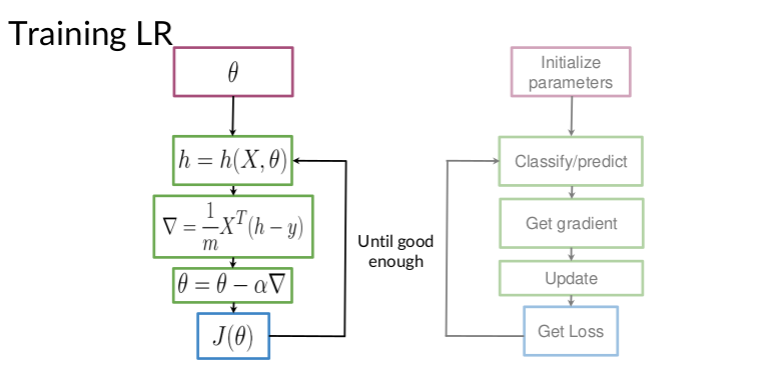

In [398]:
/x: ((1.00000000e+00 8.34044009e+02 1.44064899e+03);(1.00000000e+00 2.28749635e-01 6.04665145e+02);(1.00000000e+00 2.93511782e+02 1.84677190e+02);(1.00000000e+00 3.72520423e+02 6.91121454e+02);(1.00000000e+00 7.93534948e+02 1.07763347e+03);(1.00000000e+00 8.38389029e+02 1.37043900e+03);(1.00000000e+00 4.08904499e+02 1.75623487e+03);(1.00000000e+00 5.47751864e+01 1.34093502e+03);(1.00000000e+00 8.34609605e+02 1.11737966e+03);(1.00000000e+00 2.80773877e+02 3.96202978e+02));
/y : ((1.);(1.);(0.);(1.);(1.);(1.);(0.);(0.);(0.);(1.));

In [399]:
/gradientDescent[x;y;((0.0);(0.0);(0.0));1e-8;700]

In [400]:
/Function for get word's positive count and negative count.
get_pos_val:{
    v:exec pos from freqs where word=x;
    $[count v; v[0];0]
    };

get_neg_val:{
    v:exec negv from freqs where word=x;
    $[count v; v[0];0]
    };

## Process tweet

The process_tweet function will return the list of processed tweet words.

In [401]:
process_tweet:{
    x: x except punctuations;
    x: " " vs lower(x);
    x: x except stop_words;
    x: {.[stemmer;enlist x;x]}'[x];
    :`$x
    }

In [402]:
process_tweet "Today is going to be a good day"

`today`go`good`day


## Extracting the features

* Given a list of tweets, extract the features and store them in a matrix. You will extract two features.
    * The first feature is the number of positive words in a tweet.
    * The second feature is the number of negative words in a tweet. 
* Then train your logistic regression classifier on these features.
* Test the classifier on a validation set. 

In [403]:
extract_features:{[tweet]
    word_l: process_tweet[tweet];
    theta: (0.0;0.0;0.0);
    theta[1]:`float$(sum {get_pos_val x}'[word_l]);
    theta[2]:`float$(sum {get_neg_val x}'[word_l]);
    :theta;
    }

In [404]:
extract_features "Hello word!"

0 65 21f


## Training Model

To train the model:
* Stack the features for all training examples into a matrix X. 
* Call `gradientDescent`, which you've implemented above.



In [405]:
update feature:extract_features'[text] from `df

`df


In [406]:
X : exec feature from df

In [407]:
Y : `float$(exec sentiment from df)

In [408]:
res: gradientDescent[X;Y;(0.0;0.0;0.0);1e-9;1500]

In [409]:
J : res[0]
theta: res[1]

In [410]:
predict_tweet:{[tweet]
    x:extract_features[tweet];
    :sigmoid[x mmu theta]
    }

## Predict Tweet

Predict tweet function will return the sigmoid value of given word. 

* value => 0.5 ---> Positive
* value < 0.5 ---> Negative

In [411]:
predict_tweet["Hello world!"]

0.5038576


In [412]:
update y_pred:predict_tweet'[text] > 0.5 from `df_test

`df_test


In [413]:
select sum(sentiment=y_pred)% 2000 from df_test

y_pred
------
0.6505


#### The accuracy score is 65.05 %